In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

def calc_scores(df_dict):
    #creates analysis_df containing auc, precision, recall, specificity, and accuracy for each model in df_dict
    analysis_df = pd.DataFrame(columns=["model", "auc", "precision", "recall", "specificity", "accuracy"])
    for model in df_dict.keys():
        for df in df_dict[model]:
            auc = roc_auc_score(df["label"],df["pred"])
            precision = precision_score(df["label"],df["pred"].round().astype(int))
            recall = recall_score(df["label"],df["pred"].round().astype(int))
            accuracy = accuracy_score(df["label"],df["pred"].round().astype(int))
            specificity = recall_score(df["label"],df["pred"].round().astype(int), pos_label=0)
            analysis_df.loc[len(analysis_df)] = [model, auc, precision, recall, specificity, accuracy]
    return analysis_df

def gen_series_df(df_dict, averaging_method):
    #create dfs with scores based on max score for series, average score for series, or some form of weighted average for series (maybe exponential?)
    all_series_dfs = dict()
    for model in df_dict.keys():
        for df in df_dict[model]:
            series_level_df = pd.DataFrame(columns=["pid", "date", "series_description", "pred",'label'])
            for pid in df['pid'].unique():
                pdf = df[df['pid'] == pid]
                for date in df['date'].unique():
                    ddf = pdf[pdf['date'] == date]
                    for series in ddf['series_description'].unique():
                        sdf = ddf[ddf['series_description'] == series]
                        if averaging_method == "max":
                            pred = sdf['pred'].max()
                        elif averaging_method == "average":
                            pred = sdf['pred'].mean()
                        elif averaging_method == "weighted":
                            pred = np.average(sdf['pred'], weights=sdf['pred'])
                        elif averaging_method == "weighted_exponential":
                            pred = np.average(sdf['pred'], weights=np.exp(sdf['pred']))
                        elif averaging_method == "weighted_z": #weights are based on 1 - (distance from the midpoint)
                            all_z_coords = sdf['z_coord'].to_numpy()
                            #only weight if at least 3 unique z_coords
                            if len(np.unique(all_z_coords)) < 3:
                                weights = np.ones(len(all_z_coords))
                            else:
                                all_z_coords = all_z_coords - all_z_coords.min() #shift to start at 0
                                all_z_coords = all_z_coords / all_z_coords.max() #normalize to 1
                                distance_from_midpoint = np.abs(all_z_coords - 0.5)
                                weights = 1 - distance_from_midpoint
                            pred = np.average(sdf['pred'], weights=weights)
                        elif averaging_method == "weighted_z_alternate": #this one creates weights by dividing by the distance from the midpoint
                            all_z_coords = sdf['z_coord'].to_numpy()
                            #only weight if at least 3 unique z_coords
                            if len(np.unique(all_z_coords)) < 3:
                                weights = np.ones(len(all_z_coords))
                            else:
                                all_z_coords = all_z_coords - all_z_coords.min() #shift to start at 0
                                all_z_coords = all_z_coords / all_z_coords.max() #normalize to 1
                                distance_from_midpoint = np.abs(all_z_coords - 0.5)
                                epsilon = 1e-10
                                weights = 1 / (distance_from_midpoint+epsilon) #add epsilon to avoid dividing by 0
                            pred = np.average(sdf['pred'], weights=weights)
                        series_level_df.loc[len(series_level_df)] = [pid, date, series, pred, list(sdf['label'])[0]]
            if model in all_series_dfs:
                all_series_dfs[model].append(series_level_df)
            else:
                all_series_dfs[model] = [series_level_df]
    return all_series_dfs

In [ ]:
data_path = "analysis_csvs/"
all_data_dfs = dict() 
for file in os.listdir(data_path):
    if "pretrained" in file:
        model = file.split("_")[0] + "_pretrained"
    else:
        model = file.split("_")[0]
    if model in all_data_dfs:
        all_data_dfs[model].append(pd.read_csv(os.path.join(data_path, file)))
    else:
        all_data_dfs[model] = [pd.read_csv(os.path.join(data_path, file))]
    
#create dfs with scores based on max score for series, average score for series, or some form of weighted average for series (maybe exponential?)
all_series_dfs = dict()
for model in all_data_dfs.keys():
    for df in all_data_dfs[model]:
        series_level_df = pd.DataFrame(columns=["pid", "date", "series_description", "pred",'label'])
        for pid in df['pid'].unique():
            pdf = df[df['pid'] == pid]
            for date in df['date'].unique():
                ddf = pdf[pdf['date'] == date]
                for series in ddf['series_description'].unique():
                    sdf = ddf[ddf['series_description'] == series]
                    series_level_df.loc[len(series_level_df)] = [pid, date, series, sdf['pred'].max(), list(sdf['label'])[0]]
        if model in all_series_dfs:
            all_series_dfs[model].append(series_level_df)
        else:
            all_series_dfs[model] = [series_level_df]


#analysis based on all data points
all_frames_results = calc_scores(all_data_dfs)

#analysis based on max score for series
max_df = gen_series_df(all_data_dfs, "max")
max_results = calc_scores(max_df)

#analysis based on average score for series
average_df = gen_series_df(all_data_dfs, "average")
average_results = calc_scores(average_df)

#analysis based on weighted average for series
weighted_df = gen_series_df(all_data_dfs, "weighted")
weighted_results = calc_scores(weighted_df)

#analysis based on weighted exponential average for series
weighted_exponential_df = gen_series_df(all_data_dfs, "weighted_exponential")
weighted_exponential_results = calc_scores(weighted_exponential_df)

#analysis based on weighted z average for series
weighted_z_df = gen_series_df(all_data_dfs, "weighted_z")
weighted_z_results = calc_scores(weighted_z_df)

#analysis based on weighted z alternate average for series
weighted_z_alternate_df = gen_series_df(all_data_dfs, "weighted_z_alternate")
weighted_z_alternate_results = calc_scores(weighted_z_alternate_df)

all_results = {"all_frames": all_frames_results, "max": max_results, "average": average_results, "weighted": weighted_results, "weighted_exponential": weighted_exponential_results, "weighted_z": weighted_z_results, "weighted_z_alternate": weighted_z_alternate_results}

#analysis based on z-axis - keep only 25-75 quartiles of data? Or only exclude apex? 
#analysis based on time stamp? 

/tmp/ipykernel_1403426/2666181844.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(all_results.keys()))  # Get a colormap with a different color for each method
/tmp/ipykernel_1403426/2666181844.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(list(all_results.keys()), rotation=45, ha='right')


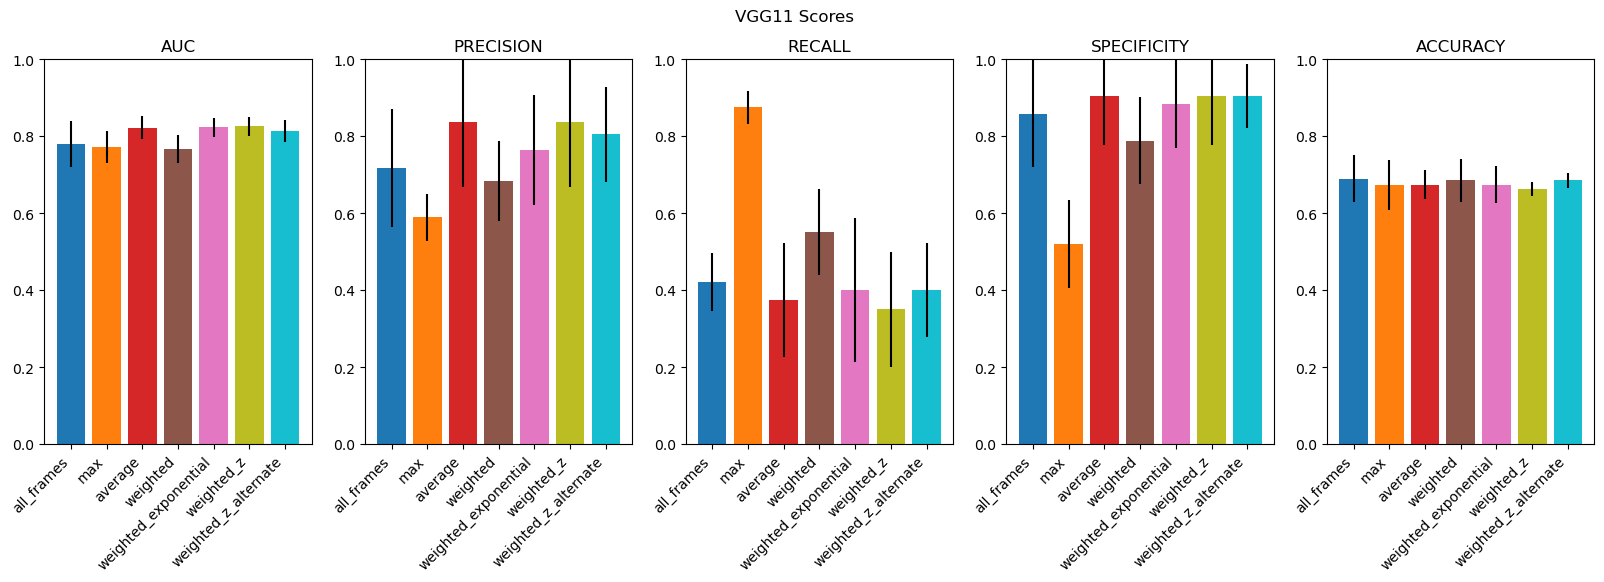

/tmp/ipykernel_1403426/2666181844.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(list(all_results.keys()), rotation=45, ha='right')


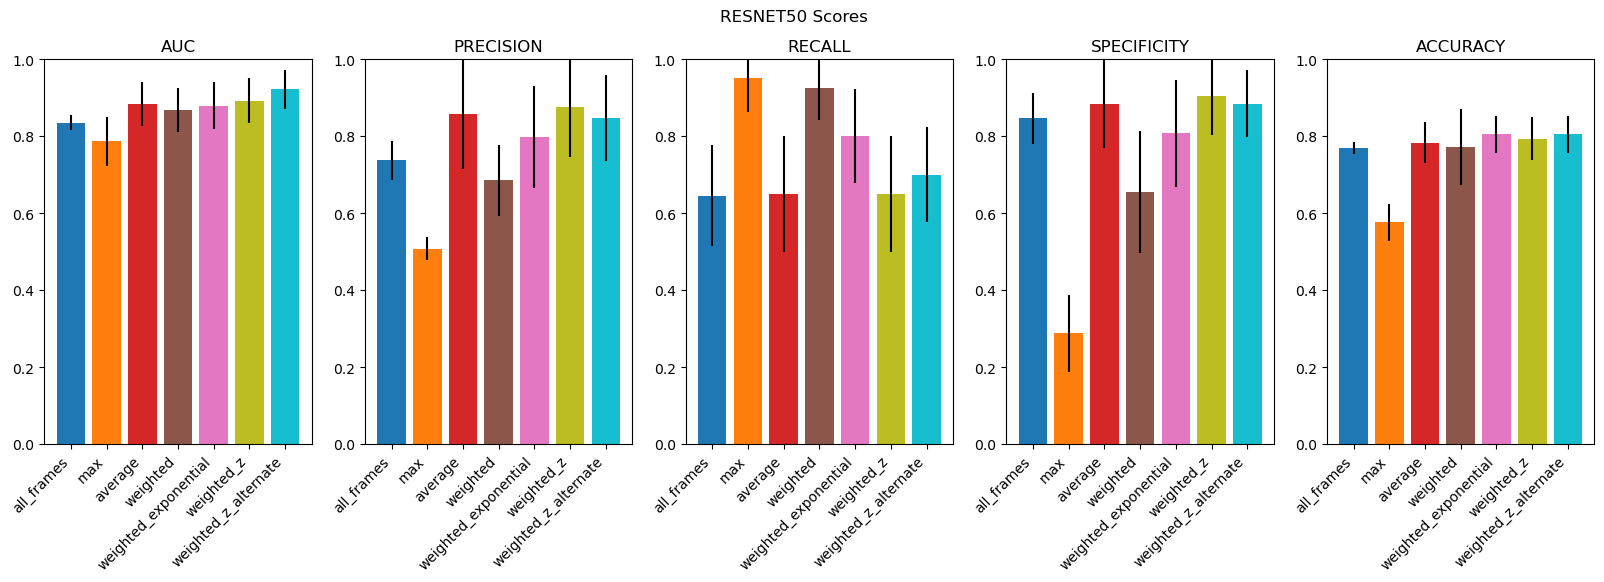

/tmp/ipykernel_1403426/2666181844.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(list(all_results.keys()), rotation=45, ha='right')


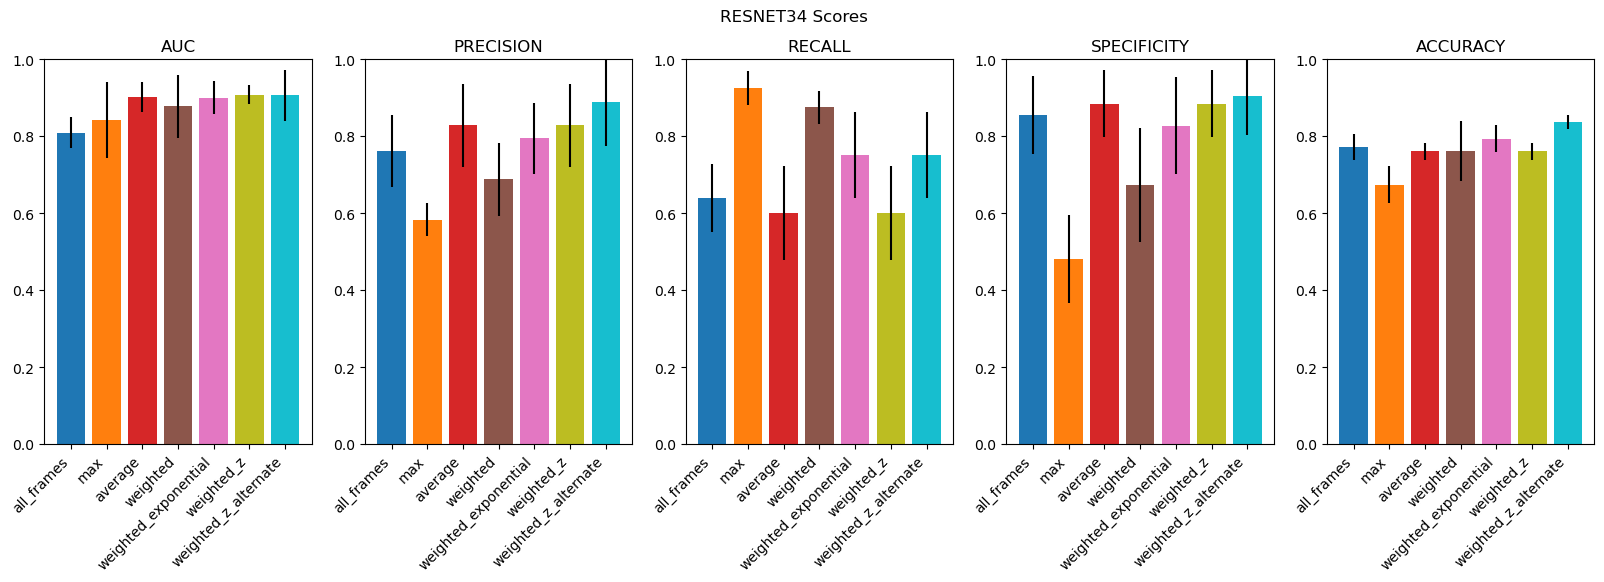

/tmp/ipykernel_1403426/2666181844.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(list(all_results.keys()), rotation=45, ha='right')


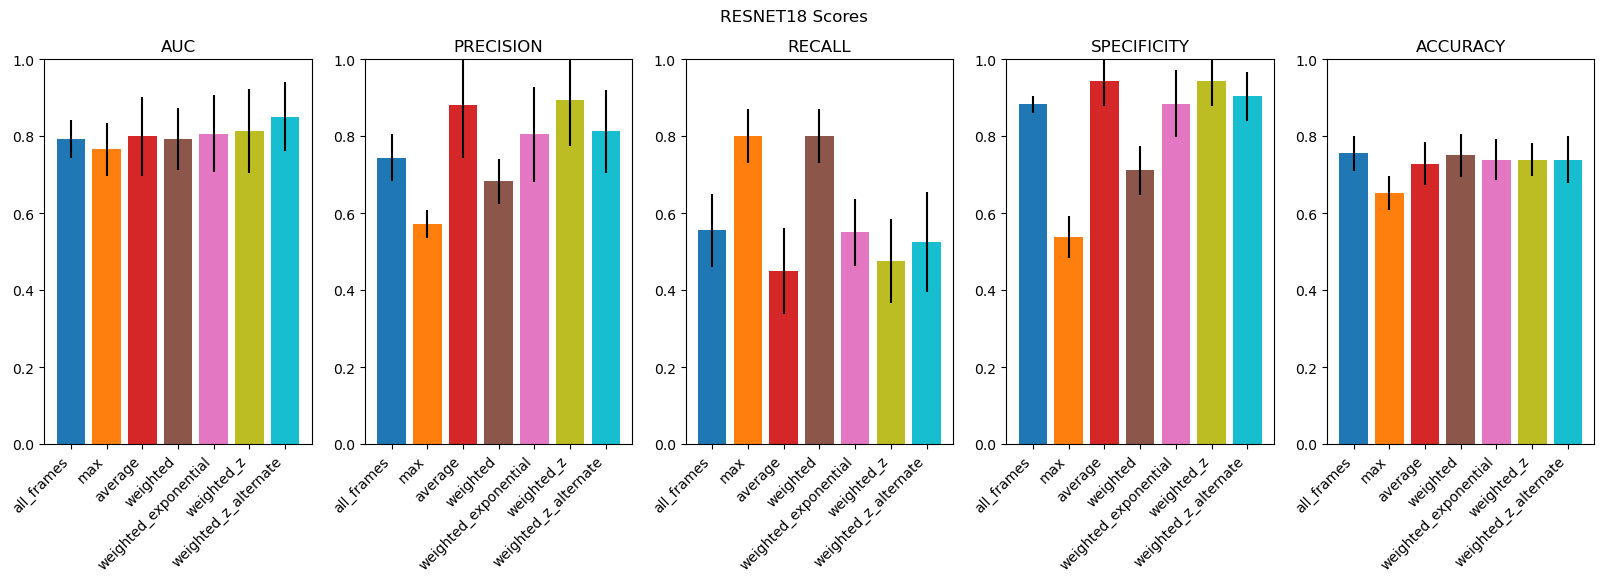

/tmp/ipykernel_1403426/2666181844.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(list(all_results.keys()), rotation=45, ha='right')


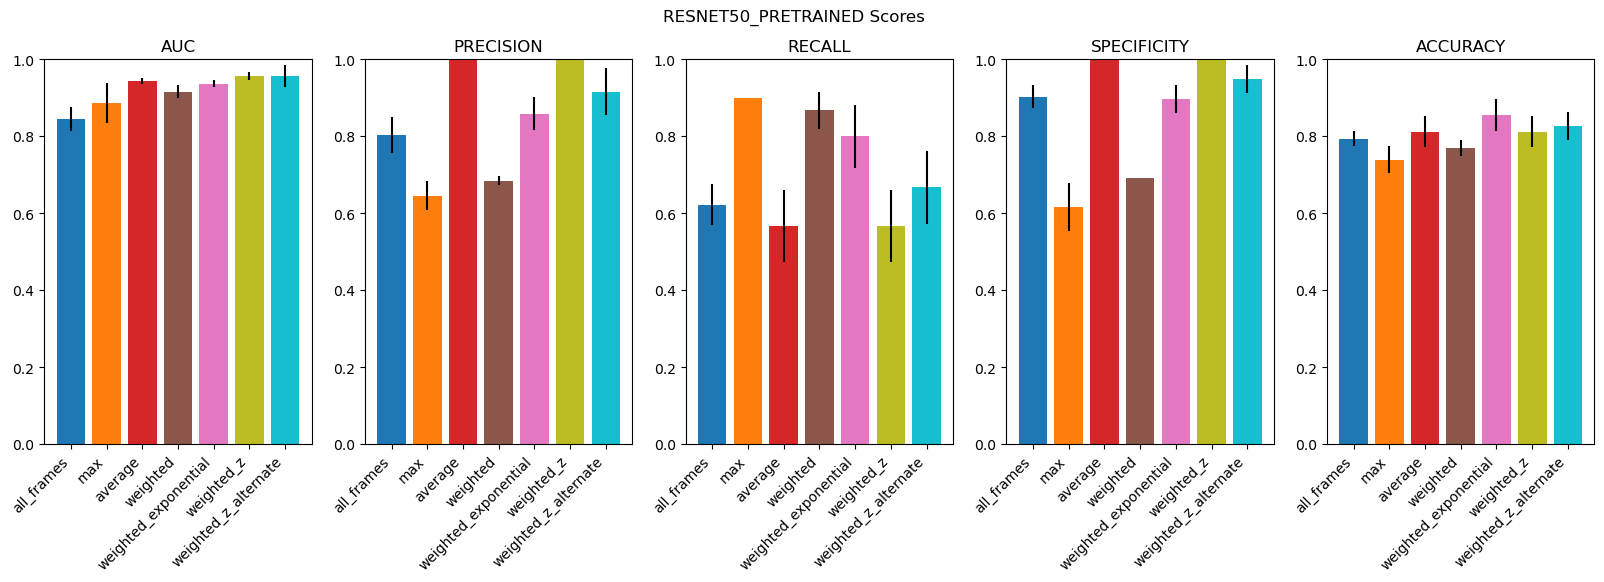

In [3]:
metrics = ["auc", "precision", "recall", "specificity", "accuracy"]
colors = plt.cm.get_cmap('tab10', len(all_results.keys()))  # Get a colormap with a different color for each method
all_models = all_frames_results['model'].unique()
for model in all_models:
    fig,ax = plt.subplots(1,5,figsize=(20,5))
    fig.suptitle(f"{model.upper()} Scores")
    for i,metric in enumerate(metrics):
        all_scores = []
        all_std = []
        for method in all_results.keys():
            model_scores = all_results[method][all_results[method]['model'] == model][metric].to_numpy()
            all_scores.append(np.mean(model_scores))
            all_std.append(np.std(model_scores))
        ax[i].bar(list(all_results.keys()), all_scores, yerr=all_std,color=[colors(j) for j in range(len(all_results.keys()))])
        ax[i].set_title(f"{metric.upper()}")
        ax[i].set_ylim(0,1)
        ax[i].set_xticklabels(list(all_results.keys()), rotation=45, ha='right')
    plt.savefig(f'images/{model}_results.jpg')
    plt.show()
        # print(f"{method} {metric}: {score} +/- {std}")